## Simple **propagation** tests using known cases

In [1]:
import numpy as np
import LightPipes as lp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from propagation import fresnel_propagation, fraunhofer_propagation
from focal_spot_pattern import create_gaussian_mask, create_slit_pattern_rand_smooth
from set_simulation import simulate_intensity_images, compute_g2, compute_inclined_lineout

### Square aperture - near field

In [2]:
grid_dimension = 150
lambda_ = 2.75e-10
I0 = 1e6
z = 1

In [3]:
N_F = [1, 4, 10]

In [4]:
F_in = []
E_in = []

F_out = []
E_out = []

for n in N_F:
    w = np.sqrt(n*lambda_*z)
    grid_size = 6*w

    dx = grid_size/grid_dimension

    f_in = lp.Begin(grid_size, lambda_, grid_dimension)
    f_in = lp.RectAperture(f_in, 2*w, 2*w)
    F_in.append(f_in)

    x = np.linspace(-dx*grid_dimension/2, dx*grid_dimension/2, grid_dimension, endpoint=False)
    y = np.linspace(-dx*grid_dimension/2, dx*grid_dimension/2, grid_dimension, endpoint=False)

    X,Y = np.meshgrid(x,y)

    e_in = np.ones([grid_dimension,grid_dimension], dtype = np.complex128)
    e_in[X<=-w] = 0 +0j
    e_in[X>=w] = 0 +0j
    e_in[Y<=-w] = 0 +0j
    e_in[Y>=w] = 0 +0j

    E_in.append(e_in)

    F_out.append(lp.Forvard(f_in, z))
    e_out = fresnel_propagation(e_in, lambda_, z, grid_size/grid_dimension, padding_factor=3)
    E_out.append(e_out)

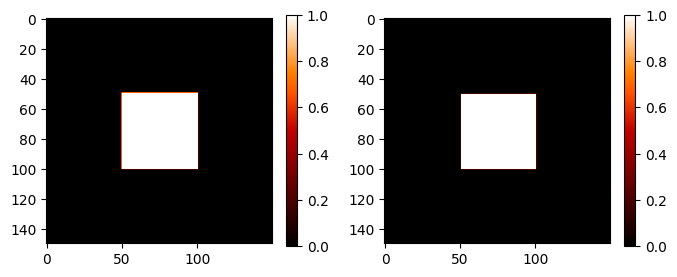

In [5]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4))

im1=ax[0].imshow(np.abs(f_in.field)**2, cmap='gist_heat')
im2=ax[1].imshow(np.abs(e_in)**2, cmap='gist_heat')

fig.colorbar(im1, ax=ax[0], shrink=0.75)
fig.colorbar(im2, ax=ax[1], shrink=0.75)

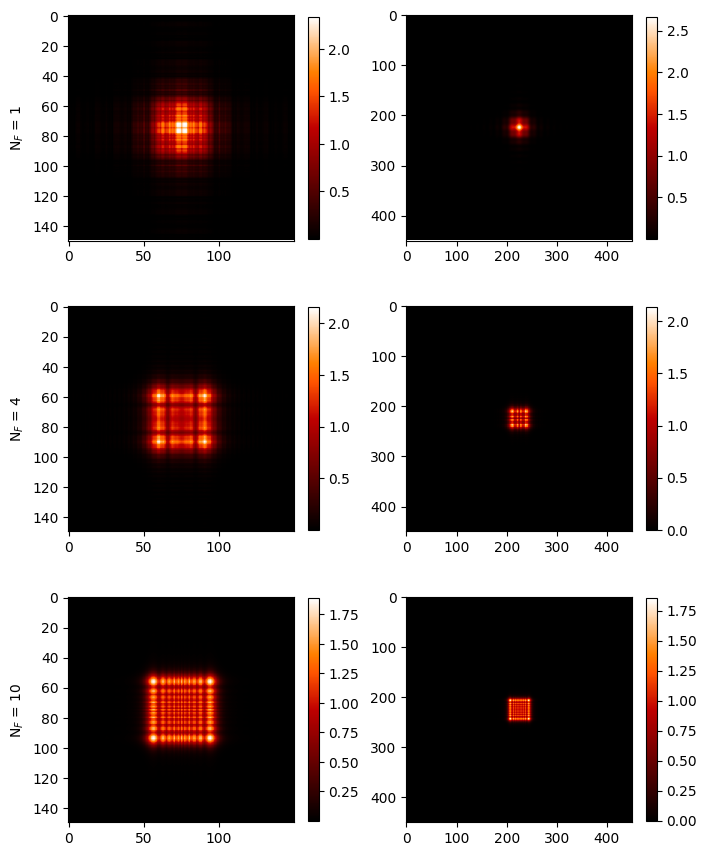

In [6]:
# intensity plots

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,4*3))

for i in range(len(E_out)):
    im1=ax[i][0].imshow(np.abs(F_out[i].field)**2, cmap='gist_heat')
    im2=ax[i][1].imshow(np.abs(E_out[i])**2, cmap='gist_heat')

    fig.colorbar(im1, ax=ax[i][0], shrink=0.65)
    fig.colorbar(im2, ax=ax[i][1], shrink=0.65)

    ax[i][0].set_ylabel(f"N$_F$ = {N_F[i]}")

fig.subplots_adjust(hspace=-0.15)

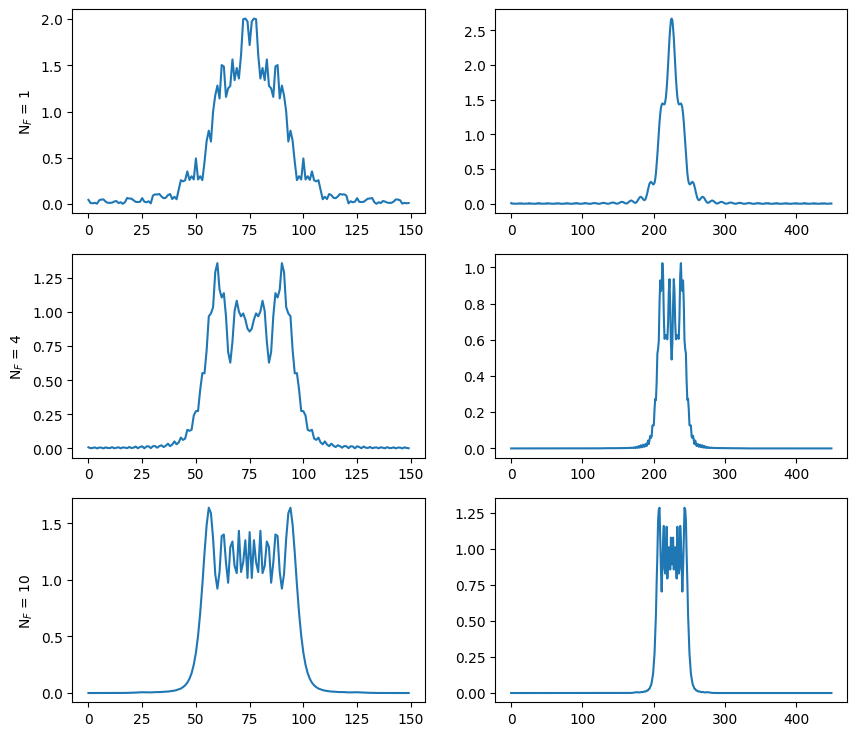

In [7]:
# intensity plots

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,3*3))

for i in range(len(E_out)):
    im1=ax[i][0].plot(np.abs(F_out[i].field[int(len(F_out[i].field)/2)])**2)
    im2=ax[i][1].plot(np.abs(E_out[i][int(len(E_out[i])/2)])**2)

    ax[i][0].set_ylabel(f"N$_F$ = {N_F[i]}")


In [8]:
# numerical comparison on number of photons
for i in range(len(N_F)):
    print("N_F =", N_F[i], "| in =", np.sum(np.abs(E_in[i])**2), "| out =", np.sum(np.abs(E_out[i])**2))

N_F = 1 | in = 2401.0 | out = 2401.0000000000014
N_F = 4 | in = 2401.0 | out = 2401.000000000001
N_F = 10 | in = 2500.0 | out = 2500.0000000000005


### Square aperture - far field

In [9]:
grid_dimension = 750
lambda_ = 2.75e-10
I0 = 1e6
z = 10

w = 25e-6

In [10]:
F_in = lp.Begin(grid_size, lambda_, grid_dimension)
F_in = lp.RectAperture(2*w, 2*w, 0, F_in)

x = np.linspace(-grid_size/2, grid_size/2, grid_dimension, endpoint=False)
y = np.linspace(-grid_size/2, grid_size/2, grid_dimension, endpoint=False)
X,Y = np.meshgrid(x,y)

E_in = np.ones([grid_dimension, grid_dimension], dtype=np.complex128)
E_in[X<=-w] = 0 +0j
E_in[X>=w] = 0 +0j
E_in[Y<=-w] = 0 +0j
E_in[Y>=w] = 0 +0j

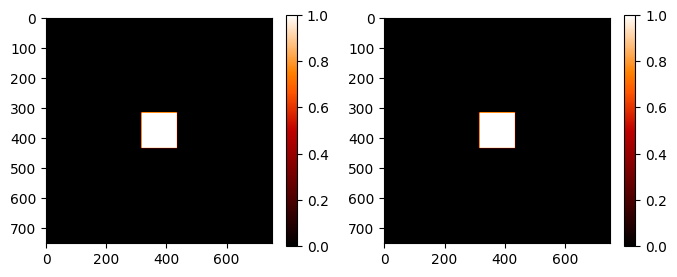

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4))

im1=ax[0].imshow(np.abs(F_in.field)**2, cmap='gist_heat')
im2=ax[1].imshow(np.abs(E_in)**2, cmap='gist_heat')

fig.colorbar(im1, ax=ax[0], shrink=0.75)
fig.colorbar(im2, ax=ax[1], shrink=0.75)

In [12]:
F_out = lp.Fresnel(F_in, z)
E_out = fraunhofer_propagation(E_in, lambda_, z, grid_size/grid_dimension, padding_factor=8)

750


In [13]:
def I_theoretical(x,y,w,lambda_,z):
    return 16*w**4/(lambda_**2*z**2)*np.sinc(2*w*x/(lambda_*z))**2*np.sinc(2*w*y/(lambda_*z))**2

I_plot = I_theoretical(X, Y, w, lambda_, z)

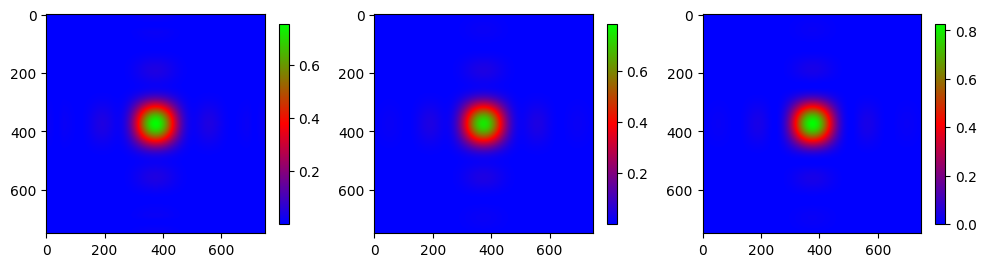

In [14]:
fig, ax = plt.subplots(ncols=3, figsize=(12,4))

im1=ax[0].imshow(np.abs(F_out.field)**2, cmap='brg')
im2=ax[1].imshow(np.abs(E_out)**2, cmap='brg')
im3=ax[2].imshow(I_plot, cmap='brg')

fig.colorbar(im1, ax=ax[0], shrink=0.65)
fig.colorbar(im2, ax=ax[1], shrink=0.65)
fig.colorbar(im3, ax=ax[2], shrink=0.65)

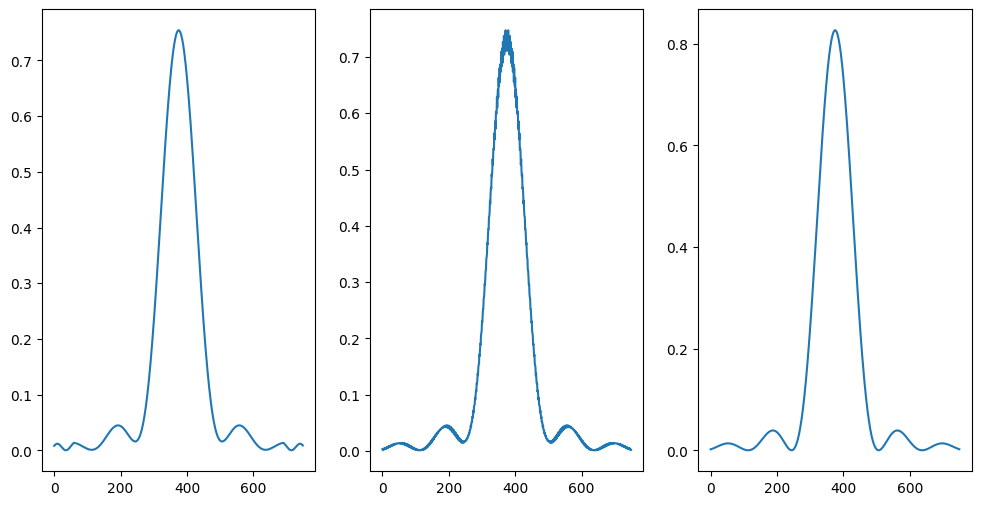

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,6))

im1=ax[0].plot(np.abs(F_out.field[int(len(F_out.field)/2)])**2)
im2=ax[1].plot(np.abs(E_out[int(len(E_out)/2)])**2)
im3=ax[2].plot(I_plot[int(len(I_plot)/2)])

In [16]:
print("in =", np.sum(np.abs(E_in)**2), "| out =", np.sum(np.abs(E_out)**2))

in = 14161.0 | out = 13210.032947445598


### Gaussian beam - near field

In [17]:
F_in = []
E_in = []

F_out = []
E_out = []

w_list = []

grid_dimension=200

def ww(w0, lambda_, z):
    return w0 * np.sqrt(1 + (lambda_*z/(np.pi*w0*w0))**2)

for n in N_F:
    w = np.sqrt(n*lambda_*z)
    grid_size = 20*w

    random_phase = 0 #np.random.uniform(0,2*np.pi, (grid_dimension, grid_dimension))

    f_in = lp.Begin(grid_size, lambda_, grid_dimension)
    f_in = lp.GaussAperture(f_in, w)
    f_in.field = f_in.field * np.exp(1j*random_phase)
    F_in.append(f_in)

    x = np.linspace(-grid_size/2, grid_size/2, grid_dimension, endpoint=False)
    y = np.linspace(-grid_size/2, grid_size/2, grid_dimension, endpoint=False)
    X,Y = np.meshgrid(x,y)

    e_in = np.exp(1j*random_phase)*create_gaussian_mask(X, Y, w=np.sqrt(2)*w)
    E_in.append(e_in)

    F_out.append(lp.Fresnel(f_in, z))
    e_out = fresnel_propagation(e_in, lambda_, z, grid_size/grid_dimension, padding_factor=8)
    E_out.append(e_out)


    w_list.append((w,ww(w, lambda_, z)))

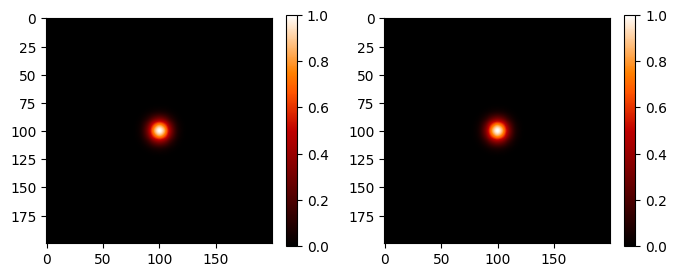

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4))

im1=ax[0].imshow(np.abs(F_in[0].field)**2, cmap='gist_heat')
im2=ax[1].imshow(np.abs(E_in[0])**2, cmap='gist_heat')

fig.colorbar(im1, ax=ax[0], shrink=0.75)
fig.colorbar(im2, ax=ax[1], shrink=0.75)

5.2440442408507573e-05 5.5033019679247374e-05
0.00010488088481701515 0.0001052124437210452
0.00016583123951776998 0.00016591522933565093


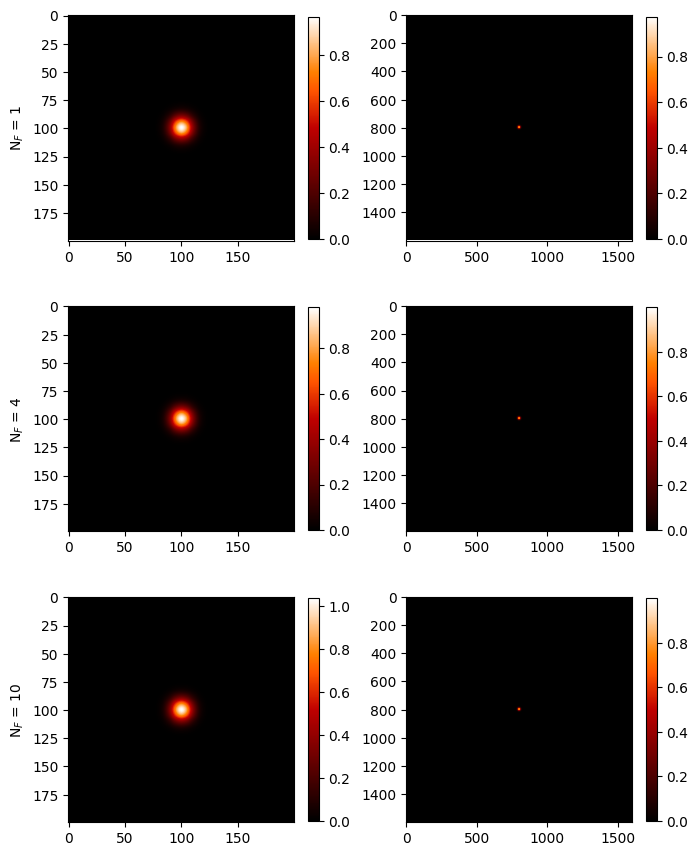

In [19]:
# intensity plots

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,4*3))

for i in range(len(E_out)):
    im1=ax[i][0].imshow(np.abs(F_out[i].field)**2, cmap='gist_heat')
    im2=ax[i][1].imshow(np.abs(E_out[i])**2, cmap='gist_heat')

    fig.colorbar(im1, ax=ax[i][0], shrink=0.65)
    fig.colorbar(im2, ax=ax[i][1], shrink=0.65)

    ax[i][0].set_ylabel(f"N$_F$ = {N_F[i]}")

    print(w_list[i][0], w_list[i][1])

fig.subplots_adjust(hspace=-0.15)

### Gaussian beam - far field

In [20]:
# known case from LightPipes

grid_size = 500e-6
lambda_ = 2.75e-10
grid_dimension = 400

w=25e-6
z=25

In [21]:
F_in = lp.Begin(grid_size, lambda_, grid_dimension)
F_in = lp.GaussAperture(F_in, w)

x = np.linspace(-grid_size/2, grid_size/2, grid_dimension)
y = np.linspace(-grid_size/2, grid_size/2, grid_dimension)
X,Y = np.meshgrid(x,y)

E_in = create_gaussian_mask(X, Y, w=np.sqrt(2)*w)

F_out = lp.Forvard(F_in, z)
E_out = fraunhofer_propagation(E_in, lambda_, z, grid_size/grid_dimension)

400


C:\Users\joaooo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\_arraypad_impl.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  padded[left_slice] = value_pair[0]
C:\Users\joaooo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\_arraypad_impl.py:151: ComplexWarning: Casting complex values to real discards the imaginary part
  padded[right_slice] = value_pair[1]


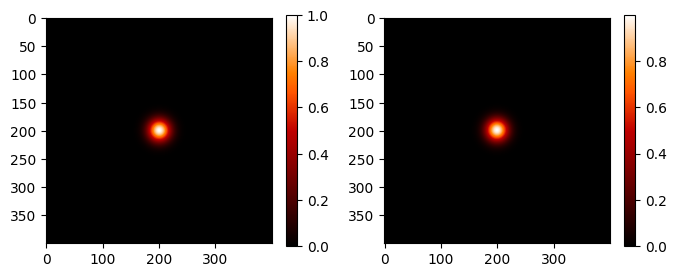

In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4))

im1=ax[0].imshow(np.abs(F_in.field)**2, cmap='gist_heat')
im2=ax[1].imshow(np.abs(E_in)**2, cmap='gist_heat')

fig.colorbar(im1, ax=ax[0], shrink=0.75)
fig.colorbar(im2, ax=ax[1], shrink=0.75)

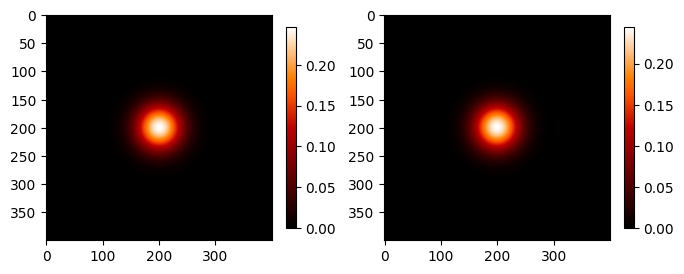

In [23]:
# intensity plots

fig, ax = plt.subplots(ncols=2, figsize=(8,4))

im1=ax[0].imshow(np.abs(F_out.field)**2, cmap='gist_heat')
im2=ax[1].imshow(np.abs(E_out)**2, cmap='gist_heat')

fig.colorbar(im1, ax=ax[0], shrink=0.65)
fig.colorbar(im2, ax=ax[1], shrink=0.65)

In [24]:
print("in =", np.sum(np.abs(E_in)**2), "| out =", np.sum(np.abs(E_out)**2))

in = 1250.3617301103714 | out = 1250.3617301103723


## Full code w/ structured grating - CDI

In [25]:
num_shots = 20
num_modes_per_shot = 1
I0 = 0.1
z_prop = 0.275
wavelength = 1.38e-10
angle = 73
num_pixels = 1000

gauss_width = 150e-6
stripe_period = 80e-6
grid_size = 1250e-6

detector_pixel_size = 13e-6

gain = 1
QE = 0.8
ADC_bits = 18

padding_factor = 2

In [26]:
dx_source = grid_size/num_pixels
dx_det_sim = dx_source
bin_factor = int(round(detector_pixel_size/dx_det_sim))

source_size = dx_source*num_pixels
x_source = np.linspace(-source_size/2, source_size/2, num_pixels, endpoint=False)
y_source = np.linspace(-source_size/2, source_size/2, num_pixels, endpoint=False)
X_source, Y_source = np.meshgrid(x_source, y_source)

# checking for sampling conditions and Fresnel number
print("Checking for Fresnel number...")
print(f"N_f = {gauss_width**2/(wavelength*z_prop)}\n")

print("Sampling conditions?")
print(bool(2*np.abs(x_source[1]-x_source[0]) >= wavelength*z_prop/source_size))

Checking for Fresnel number...
N_f = 592.885375494071

Sampling conditions?
True


In [27]:
gaussian_mask1 = create_gaussian_mask(X_source, Y_source, w=gauss_width)
extent = [x_source[0], x_source[-1], y_source[0], y_source[-1]]
grating_mask1 = create_slit_pattern_rand_smooth(X_source, Y_source, stripe_period, angle=73, dx_source=dx_source)
object_mask1 = gaussian_mask1 * grating_mask1

current_object_mask_func = create_slit_pattern_rand_smooth

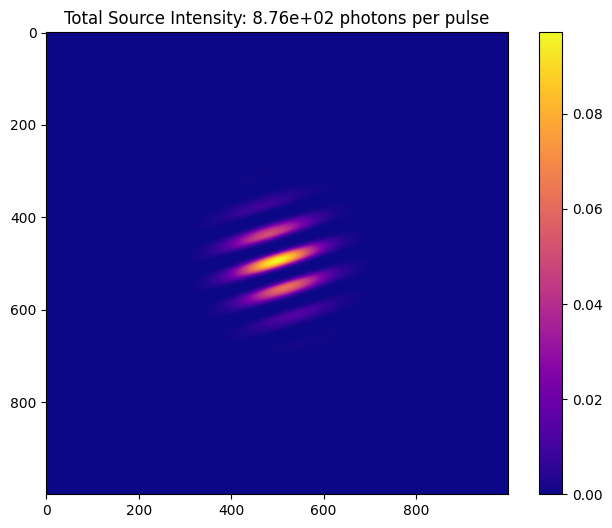

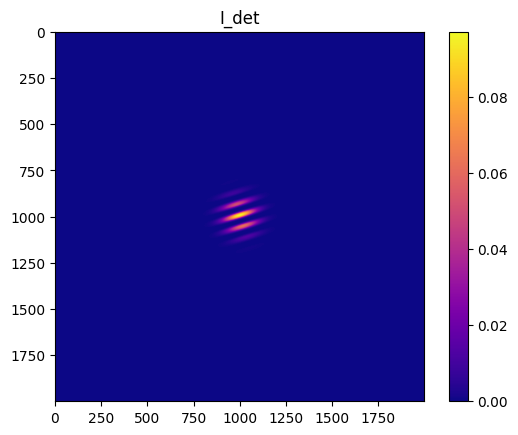

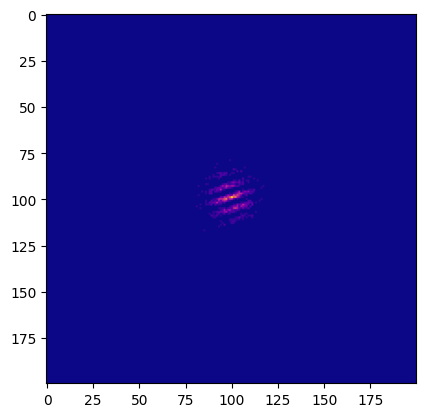

Completed Shot 1/20 - Photons per pixel: 0.08
Completed Shot 2/20 - Photons per pixel: 0.07
Completed Shot 3/20 - Photons per pixel: 0.07
Completed Shot 4/20 - Photons per pixel: 0.08
Completed Shot 5/20 - Photons per pixel: 0.07
Completed Shot 6/20 - Photons per pixel: 0.07
Completed Shot 7/20 - Photons per pixel: 0.08
Completed Shot 8/20 - Photons per pixel: 0.08
Completed Shot 9/20 - Photons per pixel: 0.07
Completed Shot 10/20 - Photons per pixel: 0.07
Completed Shot 11/20 - Photons per pixel: 0.08
Completed Shot 12/20 - Photons per pixel: 0.07
Completed Shot 13/20 - Photons per pixel: 0.07
Completed Shot 14/20 - Photons per pixel: 0.08
Completed Shot 15/20 - Photons per pixel: 0.08
Completed Shot 16/20 - Photons per pixel: 0.07
Completed Shot 17/20 - Photons per pixel: 0.08
Completed Shot 18/20 - Photons per pixel: 0.07
Completed Shot 19/20 - Photons per pixel: 0.07
Completed Shot 20/20 - Photons per pixel: 0.08


In [28]:
intensity_images, field_images = simulate_intensity_images(X_source, Y_source, num_shots, num_modes_per_shot, I0, z_prop, 
                                                          gauss_width, stripe_period,
                                                          current_object_mask_func,
                                                          num_pixels, dx_source, angle, wavelength,
                                                          bin_factor, gain, QE, ADC_bits, padding_factor)

In [29]:
avg_intensity, autocorr_avg, vertical_sum, I_per_pix = compute_g2(intensity_images)

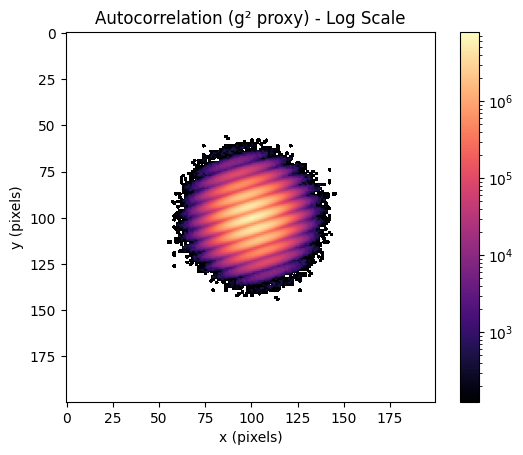

In [30]:
plt.figure()
plt.imshow(np.abs(autocorr_avg)-1 + 1e-6,norm=mcolors.LogNorm(), cmap="magma")
plt.title("Autocorrelation (g² proxy) - Log Scale")
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
plt.colorbar()
plt.show()

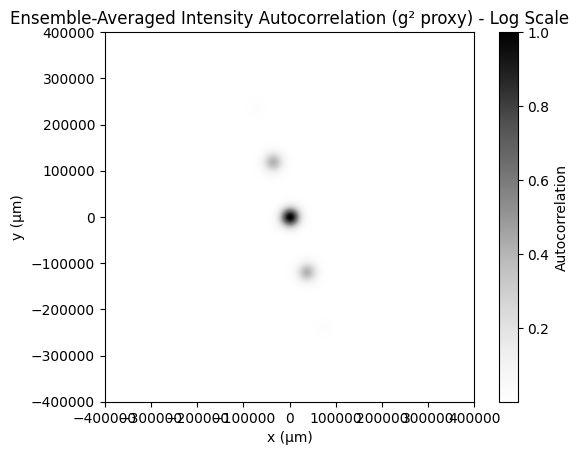

In [31]:
plt.figure()

pad_width = num_pixels * (padding_factor-1)//2
padded_E = np.pad(autocorr_avg, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant', constant_values=(0+0j,0+0j))
padded_N = padded_E.shape[0]

extent = [-1/(2*dx_source), 1/(2*dx_source), -1/(2*dx_source), 1/(2*dx_source)]
plot_func = np.abs(np.fft.fftshift(np.fft.fft2(padded_E)))
plt.imshow(plot_func/np.max(plot_func), cmap='Greys', extent=extent)
plt.title("Ensemble-Averaged Intensity Autocorrelation (g² proxy) - Log Scale")
plt.xlabel("x (µm)")
plt.ylabel("y (µm)")
plt.colorbar(label="Autocorrelation")
plt.show()

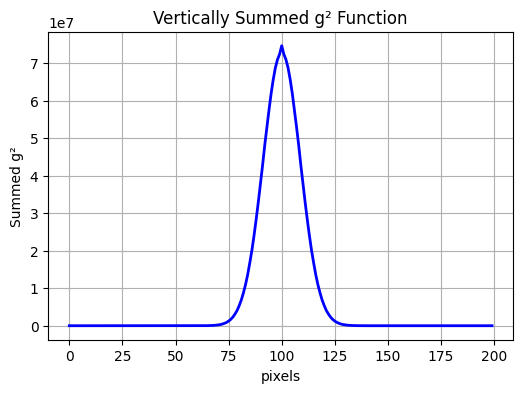

In [32]:
x_pixels = np.arange(len(vertical_sum))
x_microns = x_pixels * detector_pixel_size / bin_factor * 1e6  # Convert pixels to microns

plt.figure(figsize=(6, 4))
plt.plot(x_pixels, vertical_sum, 'b-', linewidth=2)
plt.xlabel("pixels")
plt.ylabel("Summed g²")
plt.title("Vertically Summed g² Function")
plt.grid(True)
plt.show()

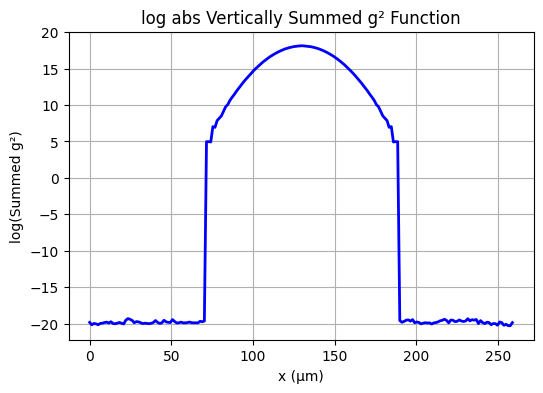

In [33]:
plt.figure(figsize=(6, 4))
plt.plot(x_microns, np.log(np.sum(np.abs(autocorr_avg), axis=0)), 'b-', linewidth=2)
plt.xlabel("x (µm)")
plt.ylabel("log(Summed g²)")
plt.title("log abs Vertically Summed g² Function")
plt.grid(True)
plt.show()

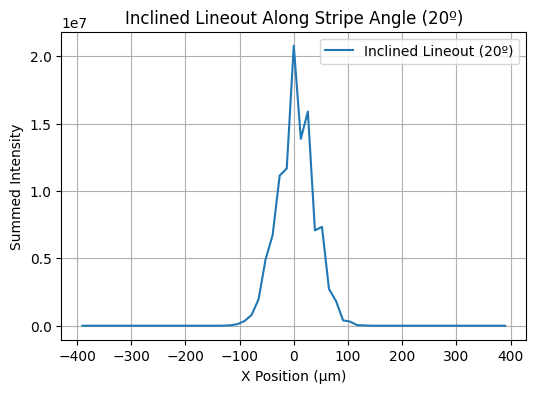

In [34]:
x_coords_um, lineout = compute_inclined_lineout(autocorr_avg, angle_deg=angle, width=5)

# Plot the lineout
plt.figure(figsize=(6, 4))
plt.plot(x_coords_um, lineout, label="Inclined Lineout (20º)")
plt.xlabel("X Position (µm)")
plt.ylabel("Summed Intensity")
plt.title("Inclined Lineout Along Stripe Angle (20º)")
plt.legend()
plt.grid()
plt.show()

## Full code w/ structured grating - IDI

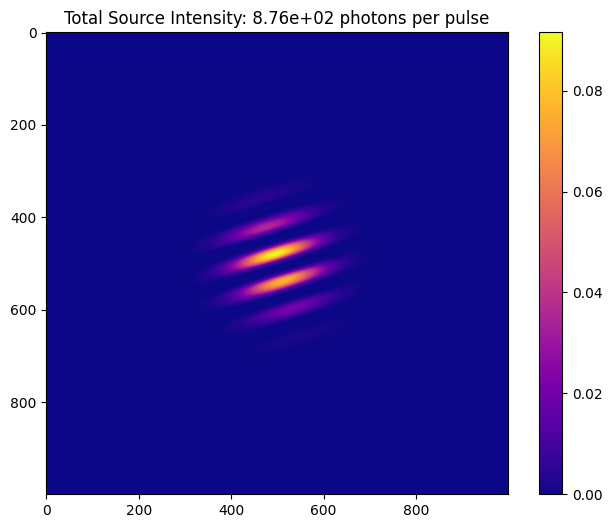

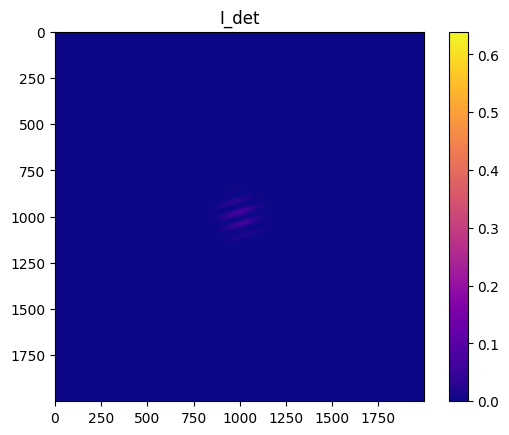

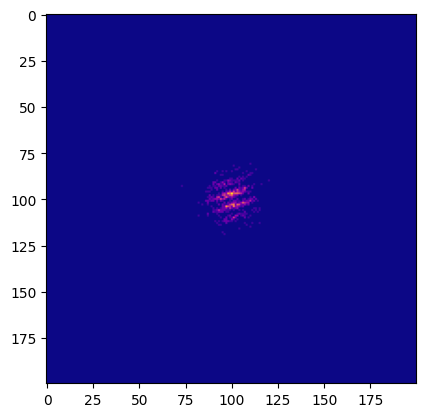

Completed Shot 1/20 - Photons per pixel: 0.07
Completed Shot 2/20 - Photons per pixel: 0.07
Completed Shot 3/20 - Photons per pixel: 0.07
Completed Shot 4/20 - Photons per pixel: 0.08
Completed Shot 5/20 - Photons per pixel: 0.08
Completed Shot 6/20 - Photons per pixel: 0.07
Completed Shot 7/20 - Photons per pixel: 0.08
Completed Shot 8/20 - Photons per pixel: 0.07
Completed Shot 9/20 - Photons per pixel: 0.07
Completed Shot 10/20 - Photons per pixel: 0.08
Completed Shot 11/20 - Photons per pixel: 0.08
Completed Shot 12/20 - Photons per pixel: 0.08
Completed Shot 13/20 - Photons per pixel: 0.07
Completed Shot 14/20 - Photons per pixel: 0.07
Completed Shot 15/20 - Photons per pixel: 0.07
Completed Shot 16/20 - Photons per pixel: 0.07
Completed Shot 17/20 - Photons per pixel: 0.07
Completed Shot 18/20 - Photons per pixel: 0.07
Completed Shot 19/20 - Photons per pixel: 0.07
Completed Shot 20/20 - Photons per pixel: 0.07


In [35]:
intensity_images, field_images = simulate_intensity_images(X_source, Y_source, num_shots, num_modes_per_shot, I0, z_prop, 
                                                          gauss_width, stripe_period,
                                                          current_object_mask_func,
                                                          num_pixels, dx_source, angle, wavelength,
                                                          bin_factor, gain, QE, ADC_bits, padding_factor, incoherent=True)

In [36]:
avg_intensity, autocorr_avg, vertical_sum, I_per_pix = compute_g2(intensity_images)

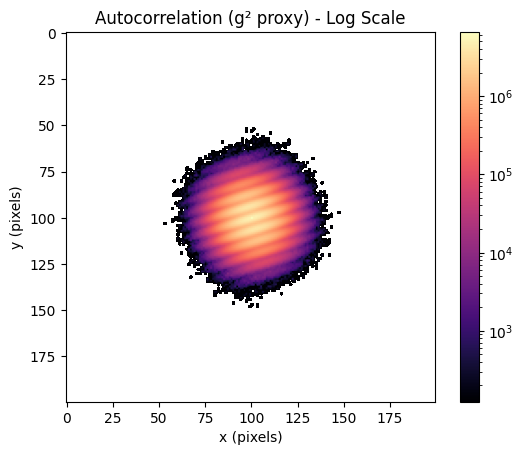

In [37]:
plt.figure()
plt.imshow(np.abs(autocorr_avg)-1 + 1e-6,norm=mcolors.LogNorm(), cmap="magma")
plt.title("Autocorrelation (g² proxy) - Log Scale")
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
plt.colorbar()
plt.show()

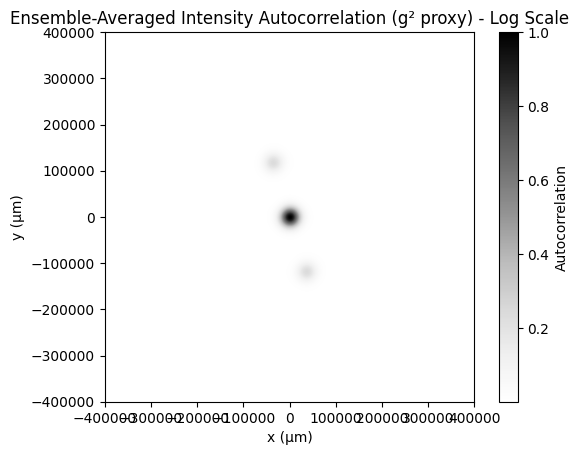

In [38]:
plt.figure()

pad_width = num_pixels * (padding_factor-1)//2
padded_E = np.pad(autocorr_avg, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant', constant_values=(0+0j,0+0j))
padded_N = padded_E.shape[0]

extent = [-1/(2*dx_source), 1/(2*dx_source), -1/(2*dx_source), 1/(2*dx_source)]
plot_func = np.abs(np.fft.fftshift(np.fft.fft2(padded_E)))
plt.imshow(plot_func/np.max(plot_func), cmap='Greys', extent=extent)
plt.title("Ensemble-Averaged Intensity Autocorrelation (g² proxy) - Log Scale")
plt.xlabel("x (µm)")
plt.ylabel("y (µm)")
plt.colorbar(label="Autocorrelation")
plt.show()

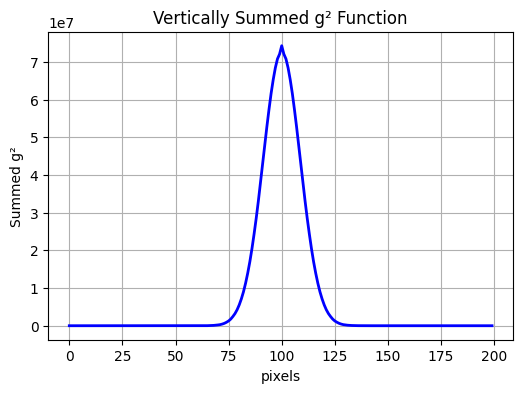

In [39]:
x_pixels = np.arange(len(vertical_sum))
x_microns = x_pixels * detector_pixel_size / bin_factor * 1e6  # Convert pixels to microns

plt.figure(figsize=(6, 4))
plt.plot(x_pixels, vertical_sum, 'b-', linewidth=2)
plt.xlabel("pixels")
plt.ylabel("Summed g²")
plt.title("Vertically Summed g² Function")
plt.grid(True)
plt.show()

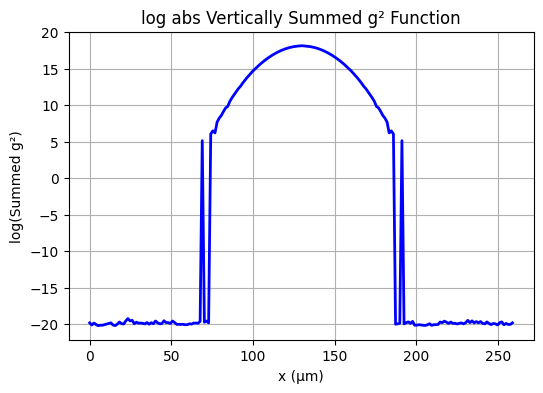

In [40]:
plt.figure(figsize=(6, 4))
plt.plot(x_microns, np.log(np.sum(np.abs(autocorr_avg), axis=0)), 'b-', linewidth=2)
plt.xlabel("x (µm)")
plt.ylabel("log(Summed g²)")
plt.title("log abs Vertically Summed g² Function")
plt.grid(True)
plt.show()

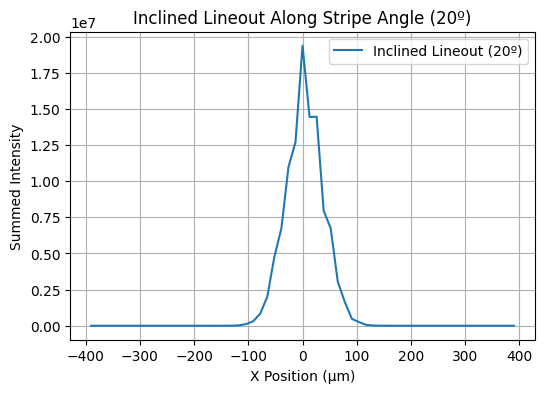

In [41]:
x_coords_um, lineout = compute_inclined_lineout(autocorr_avg, angle_deg=angle, width=5)

# Plot the lineout
plt.figure(figsize=(6, 4))
plt.plot(x_coords_um, lineout, label="Inclined Lineout (20º)")
plt.xlabel("X Position (µm)")
plt.ylabel("Summed Intensity")
plt.title("Inclined Lineout Along Stripe Angle (20º)")
plt.legend()
plt.grid()
plt.show()

## Full code w/ structured grating & custom values - IDI

In [42]:
num_shots = 20
num_modes_per_shot = 1
I0 = 1
z_prop = 1
wavelength = 2.75e-10
angle = 73
num_pixels = 400

gauss_width = 25e-6
stripe_period = 0.5e-6
grid_size = 200e-6

detector_pixel_size = 13e-6

gain = 1
QE = 0.8
ADC_bits = 18

padding_factor = 4

In [43]:
dx_source = grid_size/num_pixels
dx_det_sim = dx_source
bin_factor = int(round(detector_pixel_size/dx_det_sim))

source_size = dx_source*num_pixels
x_source = np.linspace(-source_size/2, source_size/2, num_pixels, endpoint=False)
y_source = np.linspace(-source_size/2, source_size/2, num_pixels, endpoint=False)
X_source, Y_source = np.meshgrid(x_source, y_source)

# checking for sampling conditions and Fresnel number
print("Checking for Fresnel number...")
print(f"N_f = {gauss_width**2/(wavelength*z_prop)}\n")

print("Sampling conditions?")
print(bool(2*np.abs(x_source[1]-x_source[0]) >= wavelength*z_prop/source_size))

Checking for Fresnel number...
N_f = 2.272727272727273

Sampling conditions?
False


In [44]:
gaussian_mask1 = create_gaussian_mask(X_source, Y_source, w=gauss_width)
extent = [x_source[0], x_source[-1], y_source[0], y_source[-1]]
grating_mask1 = create_slit_pattern_rand_smooth(X_source, Y_source, stripe_period, angle=73, dx_source=dx_source)
object_mask1 = gaussian_mask1 * grating_mask1

current_object_mask_func = create_slit_pattern_rand_smooth

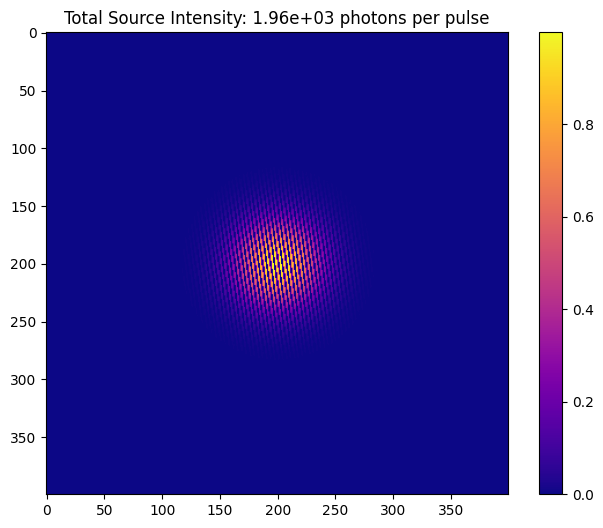

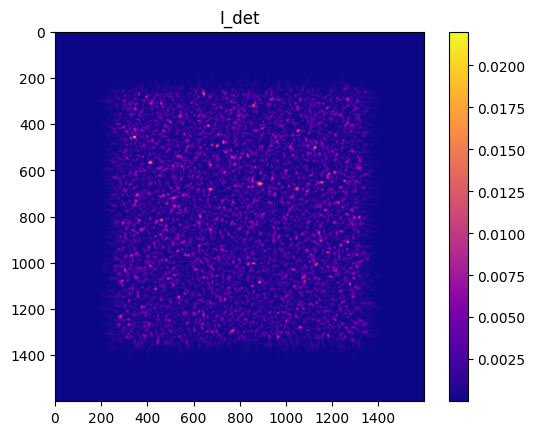

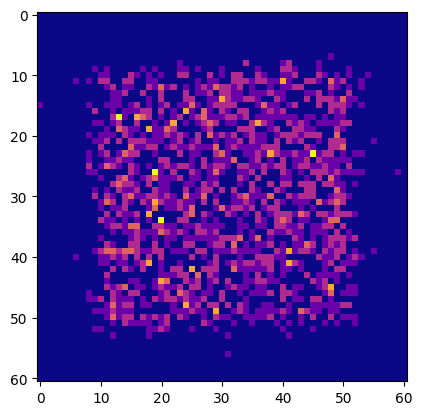

Completed Shot 1/20 - Photons per pixel: 7.65
Completed Shot 2/20 - Photons per pixel: 7.73
Completed Shot 3/20 - Photons per pixel: 7.33
Completed Shot 4/20 - Photons per pixel: 7.28
Completed Shot 5/20 - Photons per pixel: 7.32
Completed Shot 6/20 - Photons per pixel: 7.87
Completed Shot 7/20 - Photons per pixel: 7.52
Completed Shot 8/20 - Photons per pixel: 7.31
Completed Shot 9/20 - Photons per pixel: 7.54
Completed Shot 10/20 - Photons per pixel: 7.24
Completed Shot 11/20 - Photons per pixel: 7.40
Completed Shot 12/20 - Photons per pixel: 7.63
Completed Shot 13/20 - Photons per pixel: 7.49
Completed Shot 14/20 - Photons per pixel: 7.56
Completed Shot 15/20 - Photons per pixel: 7.51
Completed Shot 16/20 - Photons per pixel: 7.44
Completed Shot 17/20 - Photons per pixel: 7.43
Completed Shot 18/20 - Photons per pixel: 7.45
Completed Shot 19/20 - Photons per pixel: 7.65
Completed Shot 20/20 - Photons per pixel: 7.33


In [45]:
intensity_images, field_images = simulate_intensity_images(X_source, Y_source, num_shots, num_modes_per_shot, I0, z_prop, 
                                                          gauss_width, stripe_period,
                                                          current_object_mask_func,
                                                          num_pixels, dx_source, angle, wavelength,
                                                          bin_factor, gain, QE, ADC_bits, padding_factor, incoherent=True)

In [46]:
avg_intensity, autocorr_avg, vertical_sum, I_per_pix = compute_g2(intensity_images)

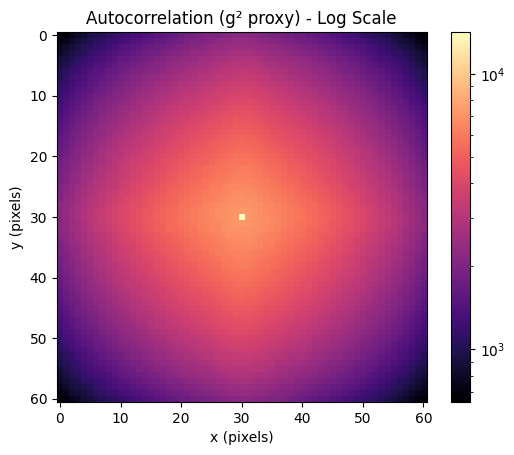

In [47]:
plt.figure()
plt.imshow(np.abs(autocorr_avg)-1 + 1e-6,norm=mcolors.LogNorm(), cmap="magma")
plt.title("Autocorrelation (g² proxy) - Log Scale")
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
plt.colorbar()
plt.show()

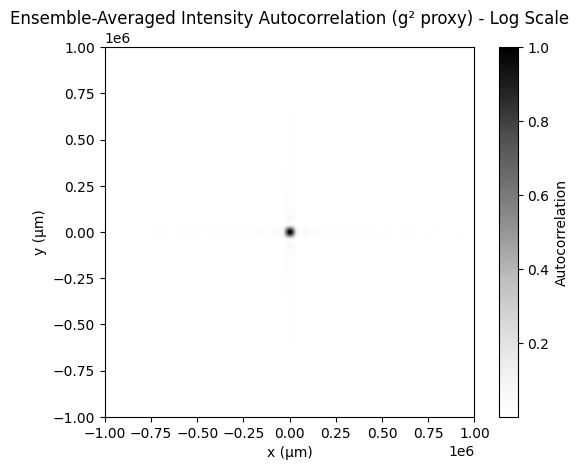

In [48]:
plt.figure()

pad_width = num_pixels * (padding_factor-1)//2
padded_E = np.pad(autocorr_avg, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant', constant_values=(0+0j,0+0j))
padded_N = padded_E.shape[0]

extent = [-1/(2*dx_source), 1/(2*dx_source), -1/(2*dx_source), 1/(2*dx_source)]
plot_func = np.abs(np.fft.fftshift(np.fft.fft2(padded_E)))
plt.imshow(plot_func/np.max(plot_func), cmap='Greys', extent=extent)
plt.title("Ensemble-Averaged Intensity Autocorrelation (g² proxy) - Log Scale")
plt.xlabel("x (µm)")
plt.ylabel("y (µm)")
plt.colorbar(label="Autocorrelation")
plt.show()

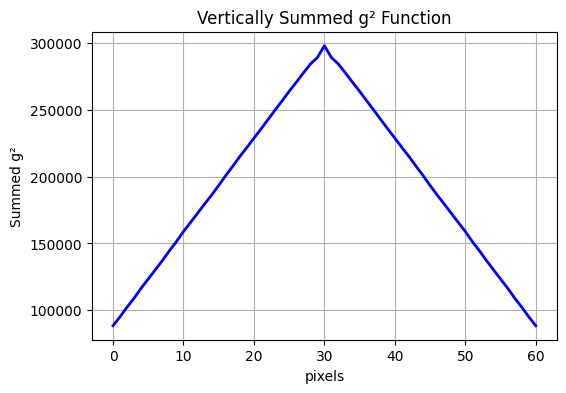

In [49]:
x_pixels = np.arange(len(vertical_sum))
x_microns = x_pixels * detector_pixel_size / bin_factor * 1e6  # Convert pixels to microns

plt.figure(figsize=(6, 4))
plt.plot(x_pixels, vertical_sum, 'b-', linewidth=2)
plt.xlabel("pixels")
plt.ylabel("Summed g²")
plt.title("Vertically Summed g² Function")
plt.grid(True)
plt.show()

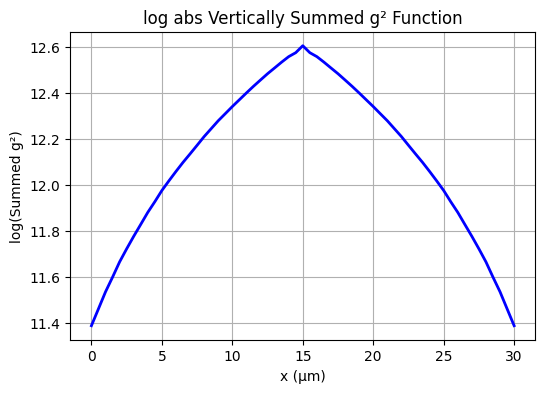

In [50]:
plt.figure(figsize=(6, 4))
plt.plot(x_microns, np.log(np.sum(np.abs(autocorr_avg), axis=0)), 'b-', linewidth=2)
plt.xlabel("x (µm)")
plt.ylabel("log(Summed g²)")
plt.title("log abs Vertically Summed g² Function")
plt.grid(True)
plt.show()

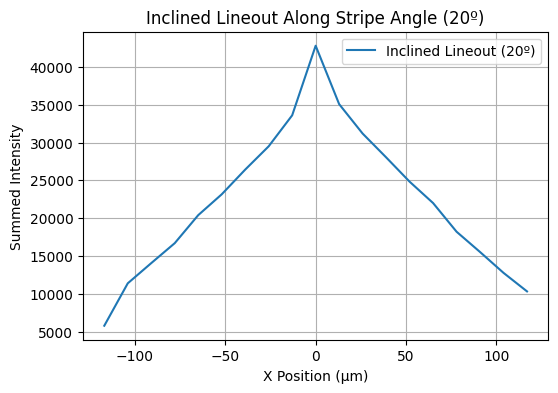

In [51]:
x_coords_um, lineout = compute_inclined_lineout(autocorr_avg, angle_deg=angle, width=5)

# Plot the lineout
plt.figure(figsize=(6, 4))
plt.plot(x_coords_um, lineout, label="Inclined Lineout (20º)")
plt.xlabel("X Position (µm)")
plt.ylabel("Summed Intensity")
plt.title("Inclined Lineout Along Stripe Angle (20º)")
plt.legend()
plt.grid()
plt.show()